# Report 2
In the first section, we analyzed one specific Job Title.
In the latter section, we analyzed the whole DB regarding the Job Sentiments per Location.

## Functions of Sentiment Analysis per Location

In [1]:
from datetime import datetime
from difflib import SequenceMatcher
from geojson import Polygon
from geojson import Feature
from ipyleaflet import Map, GeoJSON, WidgetControl, Marker, Popup, Icon
from ipywidgets import HTML
from turfpy.measurement import bbox
import ast
import math
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore')
%matplotlib inline

def loadDataFrame(jobTitle = ""): # Removing duplicates from Dataframe
    nddf = pd.read_csv('withLocation.csv')
    if(jobTitle != ""):
        newDf = pd.DataFrame()
        for i in range(len(nddf)):
            if(similar(nddf.job_title.iloc[i],jobTitle)>= 0.9):
                newDf=newDf.append([nddf.iloc[i]])
        nddf = newDf
    
    if 'job_title' in nddf.columns:
        nddf['job_title'] = nddf['job_title'].apply(str.lower)
        
    if 'tweet_id' in nddf.columns:
        nddf = nddf[~nddf.tweet_id.duplicated()]
        
    if 'location_country' in nddf.columns:   
        nddf = nddf[nddf["location_country"] == "Deutschland"]

    return nddf
    
def similar(a, b): # Avoiding traditional english translation of German State names or misspelling
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def getState(locationName): # Get the state name from the provided location of a Tweet
    locationName = locationName.lower()
    locationName = locationName.capitalize()
    with open('germany.json') as user_file:
        file_contents = user_file.read()
    y = json.loads(file_contents)
    for geoInfo in y:
        if (similar(geoInfo['name'], locationName)>=0.95):
            return(geoInfo['state'])

def avgStateSent(pointDict,convert): # Calculate the average sentiment of a job title for per city
    dct = {}
    for point,sentiment in pointDict.items():
        pos = []
        neg = []
        for i in range(len(sentiment)):
            pos.append(sentiment[i][0])
            neg.append(sentiment[i][1])
        avgPos = sum(pos)/len(pos)
        avgNeg = sum(neg)/len(neg)
        if (not convert): # If True, calculate the average per state
                dct[point] = (avgPos,avgNeg)
        else:
                if getState(point) == None:
                    dct[point] = (avgPos,avgNeg)
                else:
                    dct[getState(point)] = (avgPos,avgNeg)
    return dct

def plotLocSentOf(jobTitle, shouldPlotStatesInstead): # Plot the location and sentiment of a job title
    try:
        jobTitle = jobTitle.lower()
        nddf = loadDataFrame(jobTitle)
        print(f"Distribution of Sentiments for {jobTitle}")

        locations = nddf[nddf['job_title'] == jobTitle]['location_name'].values

        sent_pos = nddf[nddf['job_title'] ==  jobTitle]['positive_sent'].values
        sent_neg = nddf[nddf['job_title'] ==  jobTitle]['negative_sent'].values
        
        obj = {}
        for i in range(len(locations)): 
            x = locations[i]
            if (x in obj):
                y = []
                y.append(obj[x][0])
                y.append((sent_pos[i],sent_neg[i]*(-1.0)))
                obj[x] = y
            else:
                obj[x]=[(sent_pos[i],sent_neg[i]*(-1.0))]

        new_dct = avgStateSent(obj, shouldPlotStatesInstead)
        loc_sent_df = pd.DataFrame(index = [key for key in new_dct],
                                   data={
                                       'Positive': [val[0]for key,val in new_dct.items()],
                                       'Negative': [val[1]for key,val in new_dct.items()]})

        ax = loc_sent_df.plot(kind="bar", stacked=True, figsize=(5,2), fontsize=6)#, legend=False)
        loc_sent_df.sum(axis=1).plot(ax=ax, color="k")
        plt.xticks(rotation=-90)
        plt.title(jobTitle, color='black')
        ax.set_xlabel("Locations")
        ax.set_ylabel("Sentiments")
    except:
        print("No output")

def analyze(jobTitle, startDate = "", finishDate = ""): # Abalyze the Job Titles based on related city and sentiment
        nddf = loadDataFrame(jobTitle)
        
        if not 'tweet_id' in nddf.columns:
            print("No output")
            return
        
        if startDate != "":
            _date = datetime.strptime(startDate, '%y-%m-%d')
            nddf['createdAt'] = pd.to_datetime(nddf['createdAt'])
            nddf['createdAt'] = nddf['createdAt'].dt.tz_localize(None)
            nddf = nddf[(nddf['createdAt'] > _date)]

        if finishDate != "":
            _date = datetime.strptime(finishDate, '%y-%m-%d')
            nddf['createdAt'] = pd.to_datetime(nddf['createdAt'])
            nddf['createdAt'] = nddf['createdAt'].dt.tz_localize(None)
            nddf = nddf[(nddf['createdAt'] < _date)]
        
        print("The count of Job Title per City:", nddf['location_name'].value_counts(), sep='\n')
        print("\nThe total number of Job Titles for all Cities:", len(nddf['location_name']))
        oS = (nddf['positive_sent']-nddf['negative_sent']).tolist()
        if (len(oS)!=0):
            total = sum(oS) / len(oS)
        else:
            total = "N/A"
        print("\nThe overall sentiment: ",total)
        
def calcSumSentPer(jobTitle,df): # Plot the Job Title and its sentiment
        jobTitle = jobTitle.lower()
        
        newDf = pd.DataFrame()
        for i in range(len(df)):
            if(similar(df.job_title.iloc[i],jobTitle)>= 0.99):
                newDf=newDf.append([df.iloc[i]])
        nddf = newDf
        
        count = nddf['positive_sent'].count()
        
        sent_pos = nddf['positive_sent'].values
        sent_neg = nddf['negative_sent'].values
        
        total = []
        for i in range(len(nddf)): 
            sumSent = sent_pos[i]+(sent_neg[i]*(-1.0))
            total.append(sumSent)
        return (sum(total)/len(total),count)

def getPopularity(num, startDate = "", finishDate = ""): # Calculate the most popular job titles
    nddf = loadDataFrame()

    if startDate != "":
        _date = datetime.strptime(startDate, '%y-%m-%d')
        nddf['createdAt'] = pd.to_datetime(nddf['createdAt'])
        nddf['createdAt'] = nddf['createdAt'].dt.tz_localize(None)
        nddf = nddf[(nddf['createdAt'] > _date)] #& (df['createdAt'] < date)]#2013-01-01        
    if finishDate != "":
        _date = datetime.strptime(finishDate, '%y-%m-%d')
        nddf['createdAt'] = pd.to_datetime(nddf['createdAt'])
        nddf['createdAt'] = nddf['createdAt'].dt.tz_localize(None)
        nddf = nddf[(nddf['createdAt'] < _date)] #& (df['createdAt'] < date)]#2013-01-01
        

    df = nddf['job_title'].value_counts()    
    lst_sents = []
    for jobTitle in df.index.tolist():
        sumSent = calcSumSentPer(jobTitle,nddf)
        lst_sents.append((jobTitle,sumSent[0],sumSent[1]))
    ndf = pd.DataFrame(lst_sents, columns =['JobTitle', 'Avg Sent', 'Count'])
    ndf.style.set_caption("{num} Most Popular Jobs:")
    ndf.to_csv('temp.csv')
    if num != -1:
        return(ndf[:num])
    else:
        return(ndf)

def sortSent(limit): # Sort popular job by sentiment
    df = pd.read_csv('temp.csv')
    ndf = df[df['Count']>df['Count'].mean()]
    df1 = ndf.sort_values(by=['Avg Sent'], ascending = False)
    df2 = ndf.sort_values(by=['Avg Sent'], ascending = True)
    
    df['value'] = ((df['Count']/len(df))*df['Avg Sent'])
    df3 = df.sort_values(by=['value'], ascending = False)
    
    return ((df1[:limit],df2[:limit]),df3)

## Functions of Job Titles per Location "Map Visualization"

In [2]:
def getLocationBBoxWithName(country="", jobTitle=""): # Fetch location of the type bbox with a country name
    x = loadDataFrame(jobTitle)
    lst = []
    dct = {}
    if not 'tweet_id' in x.columns:
        print("No output")
        return (lst, dct)
    
    for i in range(len(x)):
        if (country!=""):
            if (x.location_country.iloc[i]==country):
                lst.append((ast.literal_eval(x.location_bbox.iloc[i]), x.job_title.iloc[i], x.location_name.iloc[i]))
                if (x.location_name.iloc[i] not in dct):
                    dct[x.location_name.iloc[i]] = 1
                dct[x.location_name.iloc[i]]=dct[x.location_name.iloc[i]]+1
        else:
            lst.append((ast.literal_eval(x.location_bbox.iloc[i]), x.job_title.iloc[i], x.location_name.iloc[i]))
            if (x.location_name.iloc[i] not in dct):
                dct[x.location_name.iloc[i]] = 1
            dct[x.location_name.iloc[i]]=dct[x.location_name.iloc[i]]+1
    return (lst, dct)

def calcLatLong(bbox): # Calculate the latitude and longitude of a bbox type 
    return((bbox[1]+bbox[3])/2,(bbox[0]+bbox[2])/2)

def bbox2poly(lst): # Converting bbox type to polygon type
    p = Polygon([[(lst[0], lst[1]),(lst[2],lst[1]),(lst[2],lst[3]),(lst[0], lst[3])]])
    return p

def random_color(feature): # Needed for polygon painting
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    return {
        'color': random.choice(colors),
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
        'fillOpacity':0
    }

# ⦿ Section 1

### Get the n = 20 popular Job Titles starting from 2017/01/01 till Today

In [3]:
getPopularity(20,"17-01-01","") # Tip: The max is len(df) - '%y-%m-%d'

,JobTitle,Avg Sent,Count
0,prospektverteiler,-0.000999,470
1,regalauffüller,-0.005914,383
2,screendesigner,-0.079421,254
3,inventurhelfer,-0.001746,206
4,kommunikationsdesigner,-0.002465,202
5,konzepter,-0.017223,196
6,mediengestalter digital und print,-0.000371,191
7,kommunikationsdesigner grafik,-0.019765,183
8,auf und abbauhelfer,-0.004499,180
9,fotoassistent,-0.026443,178


### Analyzing the popularity and sentiments of Tweets

In [4]:
result = sortSent(20)

### Sort n = 20 most popular Job Titles sorted by Average Positive Sentiments

In [5]:
result[0][0]

,Unnamed: 0,JobTitle,Avg Sent,Count
71,71,gesundheitstrainer,0.769863,22
585,585,boxtrainer,0.558618,5
280,280,restaurantfachmann,0.381567,8
573,573,radrennfahrer,0.375482,5
290,290,makeupartistin,0.364232,8
587,587,nageldesignerin,0.363753,5
404,404,forstmeister,0.304694,6
600,600,coiffeur friseur,0.289064,5
570,570,feelgoodmanagerin,0.271321,5
253,253,senior socialmediamanager,0.266995,8


### Sort n = 20 most popular Job Titles sorted by Average Negative Sentiments

In [6]:
result[0][1]

,Unnamed: 0,JobTitle,Avg Sent,Count
377,377,disponent,-0.908145,6
186,186,anwalt,-0.815811,10
622,622,bildregisseur,-0.773070,5
550,550,verkäuferin schuhe,-0.752494,5
583,583,bildreporter,-0.712960,5
236,236,insolvenzverwalterin,-0.689972,9
319,319,empfangsmitarbeiterin,-0.681074,7
486,486,chauffeurin,-0.671764,5
237,237,zugbegleiterin,-0.647203,8
187,187,zugführerin,-0.632819,10


### Second approach of analyzing most popular Jobs per Sentiment

In [7]:
result[1]

,Unnamed: 0,JobTitle,Avg Sent,Count,value
71,71,gesundheitstrainer,0.769863,22,0.004324
14,14,floristmeister,0.042883,106,0.001160
280,280,restaurantfachmann,0.381567,8,0.000779
290,290,makeupartistin,0.364232,8,0.000744
585,585,boxtrainer,0.558618,5,0.000713
...,...,...,...,...,...
40,40,triebwagenführer,-0.346944,39,-0.003454
22,22,hellseherin,-0.238890,60,-0.003659
11,11,grafikdesigner grafikdesign,-0.093239,167,-0.003975
36,36,filialleiter,-0.360489,46,-0.004233


# ⦿ Section 2

### Distribution of Sentimens of one Job Title

Distribution of Sentiments for regalauffüller


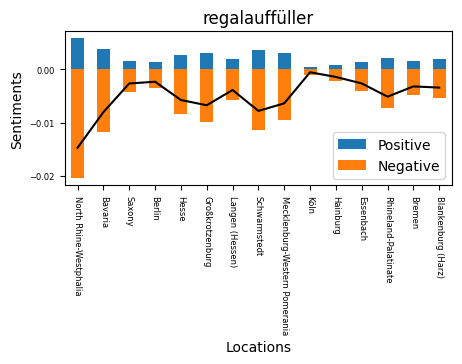

In [8]:
plotLocSentOf("regalauffüller", True) #Set it False in case of avoiding City-to-State Conversion. Note that not all cities are converted into States!

### Location distribution for a Job Title per Tweeted time query 

In [9]:
analyze("regalauffüller","","") #2nd-input:StartDate, 3rd-input:EndDate, Structure of them is like: yy-mm-dd e.g. 18-01-28

The count of Job Title per City:
Wemding               62
Rostock               55
Berlin                30
Langen (Hessen)       29
Rheinbach             28
Wiesbaden             23
Hanau                 18
Köln                  17
Schwarmstedt          10
Hainburg              10
Pfarrkirchen          10
Leipzig               10
Dormagen              10
Großkrotzenburg       10
Mühlheim am Main      10
Bruchköbel             9
Meschede               9
Seligenstadt           6
Neuss                  6
Bremen                 6
Hilden                 5
Prüm                   4
Essenbach              3
Offenbach am Main      3
Blankenburg (Harz)     1
Name: location_name, dtype: int64

The total number of Job Titles for all Cities: 384

The overall sentiment:  -0.005938833469826932


### Location Distribution Map Visualization

In [10]:
jobTitle = "regalauffüller" #Insert your desired job title here
country = "Deutschland"

########################################################

m = Map(center=[51.330, 10.453], zoom=5)
result = getLocationBBoxWithName(country, jobTitle)
for bbox, job, name in result[0]:
    geo_json = GeoJSON(data=Feature(geometry=bbox2poly(bbox)),
                style_callback=random_color)
    icon = Icon(icon_url='https://pngimg.com/uploads/dot/dot_PNG7.png', icon_size=[15, 15], shadow_size=None)
    marker = Marker(location=calcLatLong(bbox), icon=icon, draggable=False)
    
    message2 = HTML()
    message2.value = "Job: "+job.capitalize()+"</br> Location: <b>"+name+"</b>"+"</br> Frequency: "+str(result[1][name])
    
    marker.popup = message2
    
    m.add_layer(marker)
    m.add_layer(geo_json)
    
if (jobTitle == ""):
    jobTitle = "all jobs"
html = HTML()
html.layout.margin = "0px 20px 10px 20px"
html.value = f"<h4>Jobs per Tweeted Location for {jobTitle}</h4>"
control = WidgetControl(widget=html, position="topright")
m.add_control(control)

m

Map(center=[51.33, 10.453], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…